In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as copora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score,classification_report

In [2]:
plt.rcParams['figure.figsize'] = (12,8)
default_plot_colour = '#00bfbf'

In [3]:
data = pd.read_csv("fake_news_data.csv")

In [4]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Articles Classification')

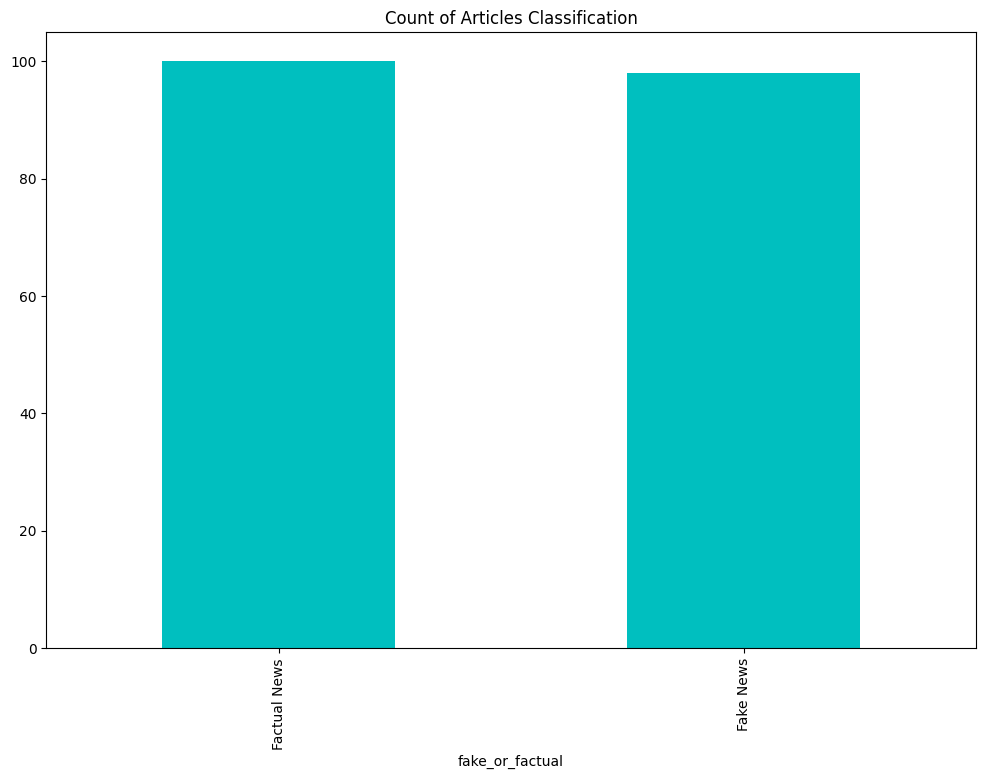

In [6]:
data['fake_or_factual'].value_counts().plot(kind='bar',color=default_plot_colour)
plt.title('Count of Articles Classification')

POS Tagging

In [7]:
nlp = spacy.load('en_core_web_sm')
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [8]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))



In [9]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type,i.pos_) for i in doc]

In [10]:
fake_tagsdf = []
columns = ['token','ner_tag','pos_tag']

In [11]:
for ix , doc in enumerate (fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)


In [12]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [13]:
factual_tagsdf = []

In [14]:
for ix, doc in enumerate (fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    factual_tagsdf.append(tags)

In [15]:
factual_tagsdf = pd.concat(factual_tagsdf)

In [16]:
factual_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,384,PROPN
1,(,0,PUNCT
2,Reuters,383,PROPN
3,),0,PUNCT
4,-,0,PUNCT


In [17]:
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)

In [18]:
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


we havent clean our data yet.

In [19]:
pos_counts_fact = factual_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [20]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [21]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [22]:
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15] # TOP 15 NOUNS USED ON THE FAKE DATASET

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [23]:
pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][:15] # TOP 15 NOUNS USED ON THE FACTUAL DATASET

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


Named entities

In [24]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag']!= "" ].groupby(['token','ner_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)
top_entities_fake[:10]

,token,ner_tag,counts
38,",",0,1871
7511,the,0,1613
53,.,0,1532
7598,to,0,1139
5914,of,0,876
2973,and,0,860
2760,a,0,790
0,,0,782
5120,in,0,676
7509,that,0,562


In [25]:
top_entities_fact = factual_tagsdf[factual_tagsdf['ner_tag']!= ""].groupby(['token','ner_tag']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)
top_entities_fact[:20]

,token,ner_tag,counts
18,",",0,1693
6264,the,0,1598
31,.,0,1382
6332,to,0,996
4904,of,0,812
2206,a,0,768
2399,and,0,742
4219,in,0,673
4937,on,0,476
5717,said,0,452


In [26]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP':sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}
display(ner_palette)

{'ORG': '#66c2a5',
 'GPE': '#fc8d62',
 'NORP': '#8da0cb',
 'PERSON': '#e78ac3',
 'DATE': '#a6d854',
 'CARDINAL': '#ffd92f',
 'PERCENT': '#e5c494'}

[Text(0.5, 1.0, 'Most Common Name Entities in Fake News')]

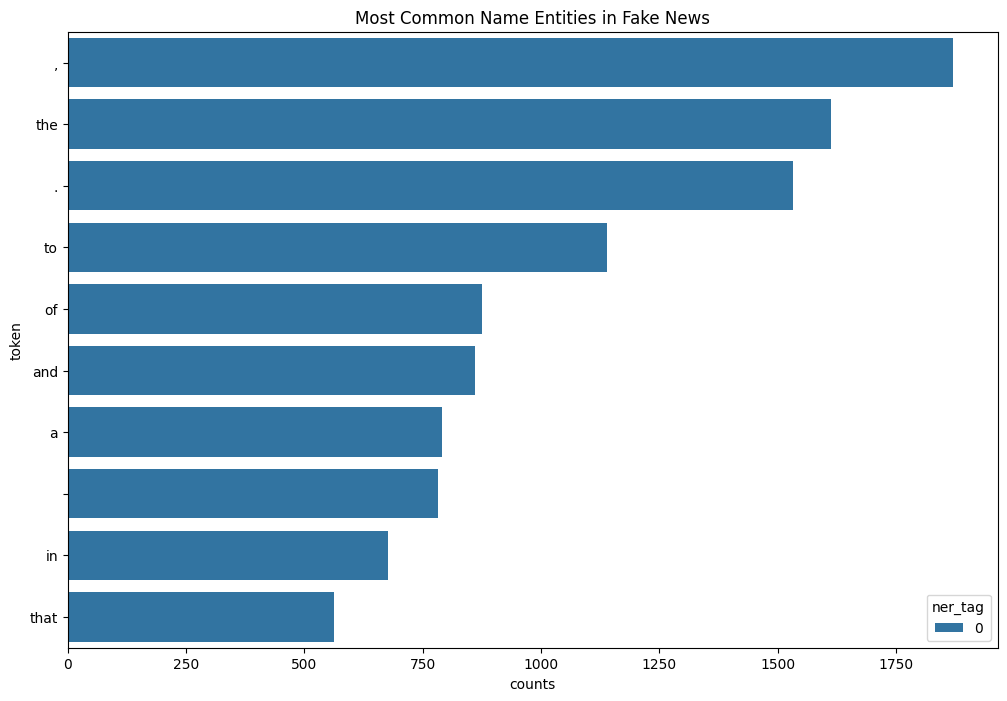

In [27]:
sns.barplot(
    x='counts',
    y = 'token',
    hue = 'ner_tag',
    data = top_entities_fake[:10],
    orient='h',
    dodge=False
).set(title='Most Common Name Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Name Entities in Factual News')]

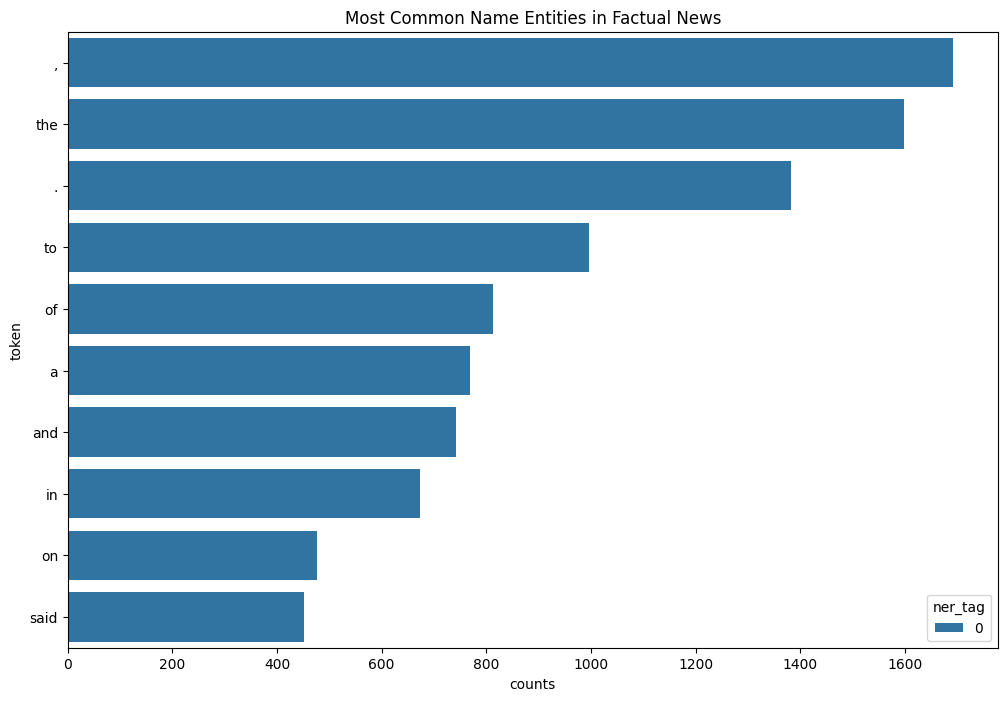

In [28]:
sns.barplot(
    x='counts',
    y = 'token',
    hue = 'ner_tag',
    data = top_entities_fact[:10],
    orient='h',
    dodge=False
).set(title='Most Common Name Entities in Factual News')

Text pre-processing

In [29]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [30]:
# look for the - and remove everything before it.
data['text_clean'] = data.apply(
    lambda x : re.sub(r'^[^-]*-\s*','',x['text']),axis=1
)

In [31]:
data['text_clean'] = data['text_clean'].str.lower()

In [32]:
data['text_clean'] = data.apply(
    lambda x: re.sub(r'([^\w\s])','',x['text_clean']),axis =1
)

In [33]:
en_stopwords = stopwords.words('english')

In [34]:
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [35]:
data['text_clean'] = data['text_clean'].apply(
    lambda x : "  ".join([word for word in x.split() if word not in (en_stopwords)]) 
)

tokenize text

In [36]:
data['text_clean'] = data.apply(
    lambda x : word_tokenize(x['text_clean']),axis = 1
)

lets use lemmatizing , it's much more smarter

In [37]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [38]:
tokens_clean = sum(data['text_clean'],[])

In [44]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean,1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


C:\Users\user\AppData\Local\Temp\ipykernel_2256\1219914495.py:4: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


[Text(0.5, 1.0, 'Most common unigrams after preprocessing')]

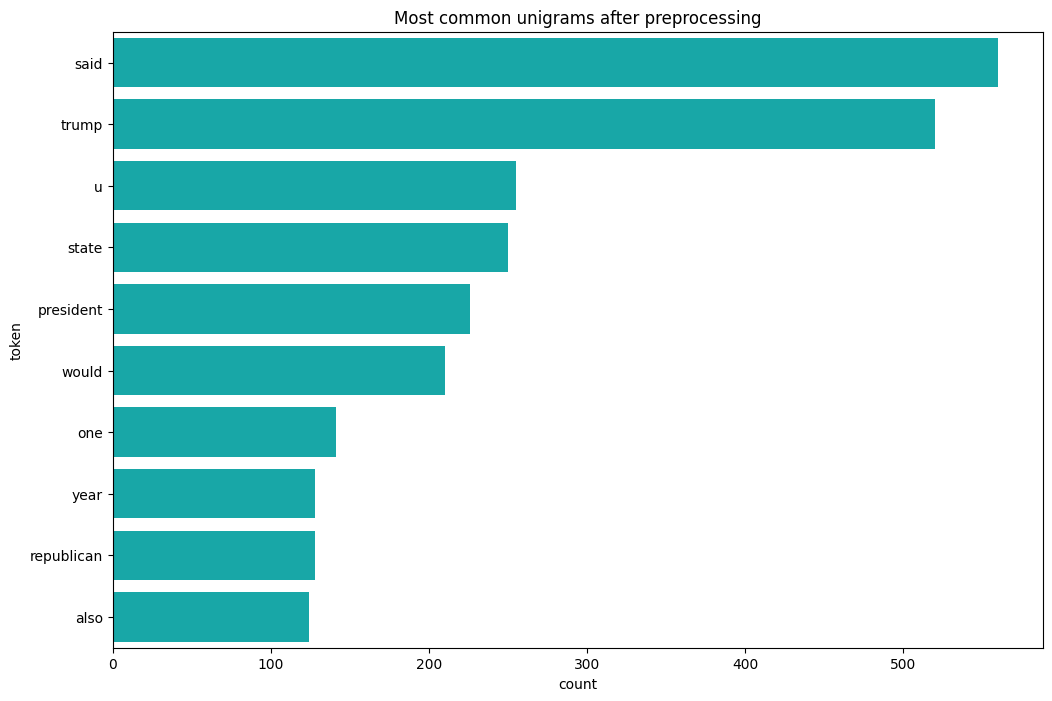

In [46]:
unigrams['token'] = unigrams['index'].apply(
    lambda x : x[0]
)
sns.barplot(
    x="count",
    y="token",
    data=unigrams,
    orient='h',
    palette=[default_plot_colour],
    hue="token",
    legend=False,
).set(title='Most common unigrams after preprocessing')

In [48]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean,2)).value_counts()).reset_index()[:10]
print(bigrams)

                 index  count
0      (donald, trump)     92
1      (united, state)     80
2       (white, house)     72
3  (president, donald)     42
4   (hillary, clinton)     31
5          (new, york)     31
6         (image, via)     29
7     (supreme, court)     29
8     (official, said)     26
9        (food, stamp)     24


Sentiment analysis


In [49]:
vader_sentiment = SentimentIntensityAnalyzer()
data['vader_sentiment_score']=data['text'].apply(
    lambda x : vader_sentiment.polarity_scores(x)['compound']
)

In [50]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [51]:
bins = [-1,-0.1,0.1,1]
names=['negative','neutral','positive']

In [53]:
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'],bins,labels=names)
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

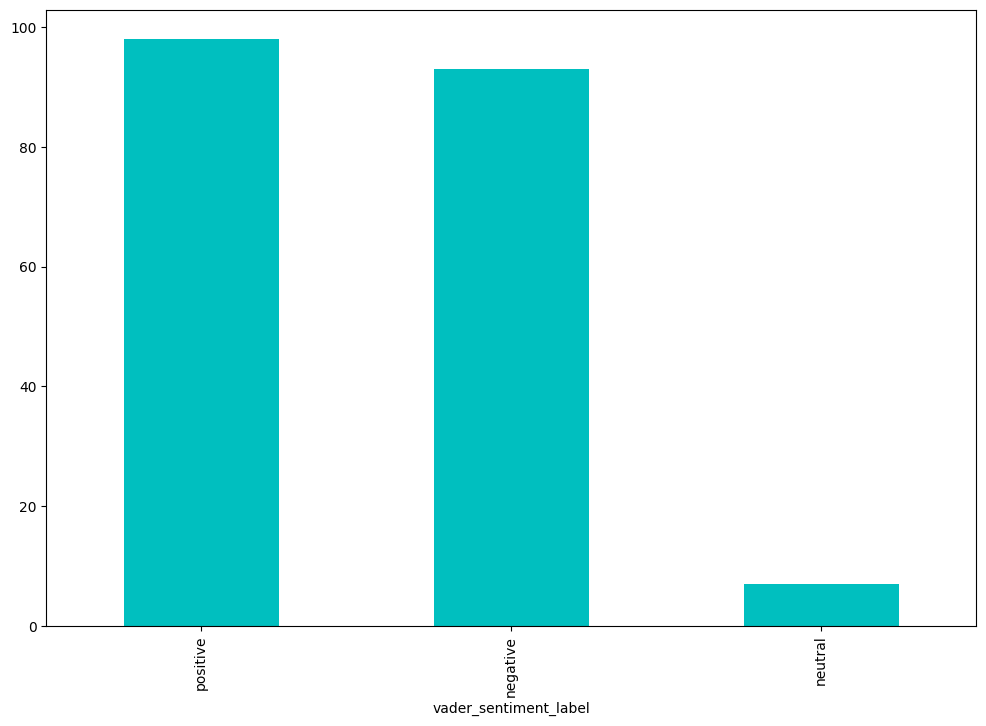

In [54]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

C:\Users\user\AppData\Local\Temp\ipykernel_2256\19405968.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

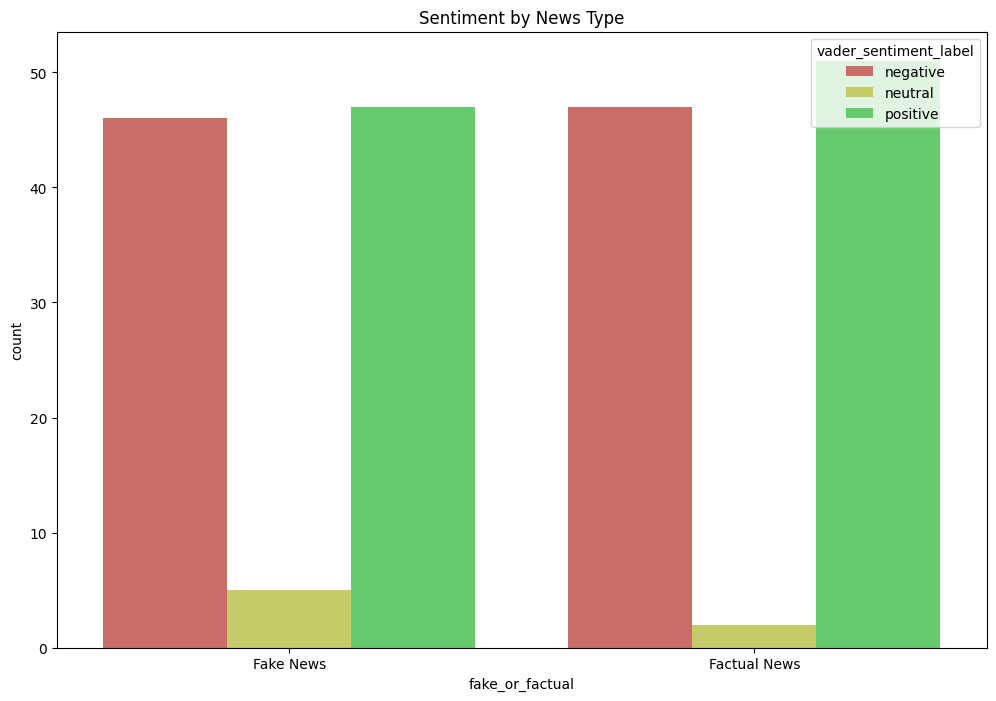

In [55]:
sns.countplot(
    x='fake_or_factual',
    hue = 'vader_sentiment_label',
    palette=sns.color_palette('hls'),
    data = data
).set(title='Sentiment by News Type')

Topic Modelling

In [65]:
fake_news_text = data[data['fake_or_factual']=='Fake News']['text_clean'].reset_index(drop=True)

In [66]:
dictionary_fake = copora.Dictionary(fake_news_text)
print(dictionary_fake)

Dictionary<5759 unique tokens: ['16yearold', 'actor', 'actress', 'aid', 'also']...>


In [67]:
doc_term_fake = [dictionary_fake.doc2bow(text)for text in fake_news_text]
print(doc_term_fake)

[[(0, 1), (1, 1), (2, 4), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 3), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [69]:
coherence_values=[]
model_list=[]

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics,max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i,id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model,texts=fake_news_text, dictionary=dictionary_fake, coherence="c_v")
    coherence_values.append(coherence_model.get_coherence())
    

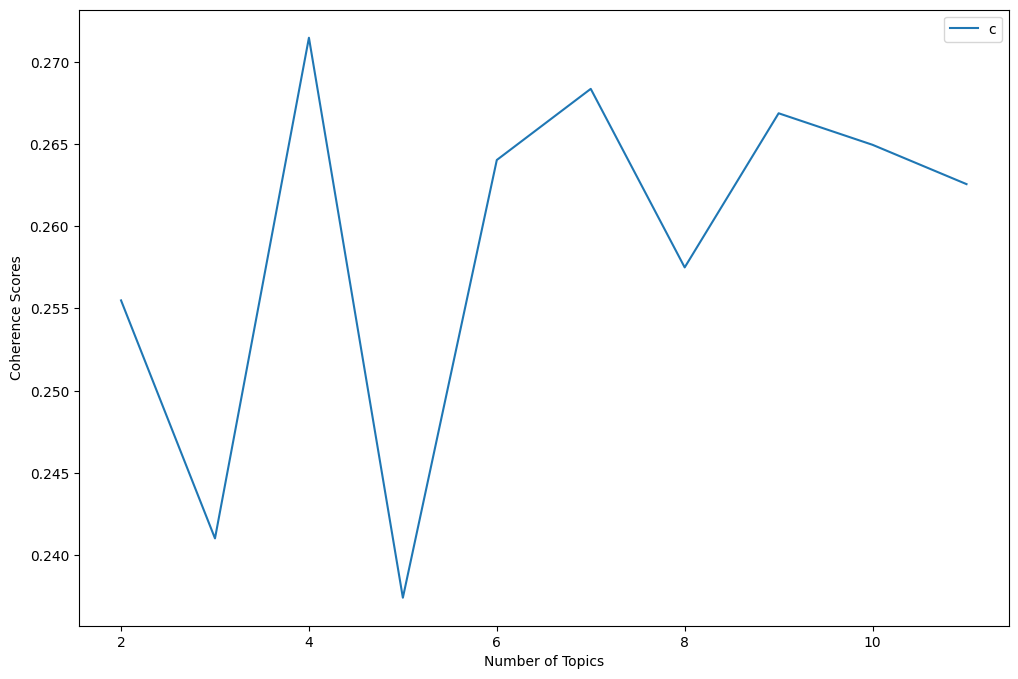

In [71]:
plt.plot(range(min_topics,max_topics+1),coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.legend(("coherence_values"),loc="best")
plt.show()

In [ ]:
num_topics_lda= 7
lda_model = gensim.models.LdaModel(corpus=doc_term_fake,id2word=dictionary_fake, num_topics=num_topics_lda)


In [74]:
lda_model.print_topics(num_topics = num_topics_lda, num_words=10)

[(0,
  '0.010*"trump" + 0.004*"woman" + 0.004*"food" + 0.004*"million" + 0.003*"money" + 0.003*"stamp" + 0.003*"clinton" + 0.003*"state" + 0.003*"image" + 0.003*"republican"'),
 (1,
  '0.006*"trump" + 0.005*"state" + 0.004*"also" + 0.004*"clinton" + 0.003*"school" + 0.003*"official" + 0.003*"president" + 0.003*"would" + 0.003*"republican" + 0.003*"even"'),
 (2,
  '0.021*"trump" + 0.006*"said" + 0.004*"president" + 0.004*"clinton" + 0.004*"republican" + 0.004*"one" + 0.004*"woman" + 0.004*"time" + 0.004*"would" + 0.003*"people"'),
 (3,
  '0.006*"trump" + 0.006*"said" + 0.006*"clinton" + 0.004*"state" + 0.004*"time" + 0.004*"president" + 0.004*"would" + 0.003*"u" + 0.003*"mccain" + 0.003*"one"'),
 (4,
  '0.016*"trump" + 0.006*"president" + 0.005*"year" + 0.005*"said" + 0.004*"obama" + 0.004*"would" + 0.004*"republican" + 0.004*"clinton" + 0.003*"one" + 0.003*"know"'),
 (5,
  '0.006*"said" + 0.005*"trump" + 0.004*"state" + 0.004*"u" + 0.004*"time" + 0.004*"would" + 0.003*"people" + 0.003*

In [75]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus =  doc_term_matrix, normalize = True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [76]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list =[]
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts=text, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherence_model.get_coherence())

    plt.plot(range(min_topics,max_topics+1), coherence_values)
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'), loc='best')
    plt.show()

In [77]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

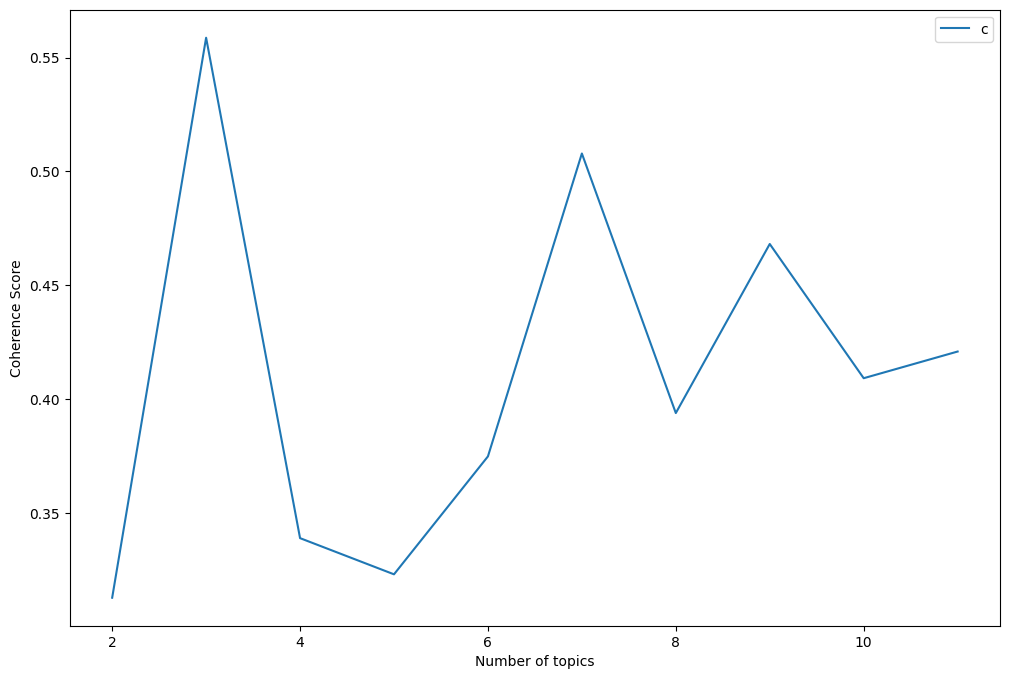

In [79]:
get_coherence_scores(corpus_tfidf_fake,dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [82]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word= dictionary_fake, num_topics= 7)
lsa_model.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '0.299*"boiler" + 0.253*"room" + 0.250*"acr" + 0.186*"jay" + 0.185*"animal" + 0.176*"episode" + 0.147*"analysis" + 0.122*"dyer" + 0.119*"mediamaniacs" + 0.119*"misguided"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '0.235*"trump" + 0.223*"flynn" + 0.166*"conference" + -0.165*"clinton" + -0.153*"dnc" + -0.151*"sander" + -0.127*"email" + 0.111*"press" + -0.109*"rich" + 0.084*"tax"'),
 (5,
  '0.246*"student" + 0.188*"school" + 0.146*"conference" + -0.128*"penny" + 0.117*"trump" 

Creating a classification model

In [83]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [84]:
X = [','.join(map(str,l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [85]:
countvec = CountVectorizer()

In [88]:
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [90]:
X_train, X_test, Y_train, Y_test= train_test_split(bag_of_words, Y, test_size=0.3)

In [91]:
lr = LogisticRegression(random_state=0).fit(X_train,Y_train)

In [92]:
y_pred_lr = lr.predict(X_test)

In [94]:
accuracy_score(y_pred_lr, Y_test)

0.8833333333333333

In [95]:
print(classification_report(Y_test,y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.90      0.87      0.89        31
   Fake News       0.87      0.90      0.88        29

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



In [96]:
svm = SGDClassifier().fit(X_train, Y_train)

In [99]:
y_pred_svm = svm.predict(X_test)

accuracy_score(y_pred_svm, Y_test)

0.9166666666666666

In [101]:
print(classification_report(Y_test,y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.91      0.94      0.92        31
   Fake News       0.93      0.90      0.91        29

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60

